In [1]:
import random
import numpy as np

# Set a fixed random seed for reproducibility
seed = 42
np.random.seed(seed)
random.seed(seed)


In [2]:
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


class GridWorld:
    ACTIONS = {
        0: (-1, 0),  # UP
        1: (1, 0),   # DOWN
        2: (0, -1),  # LEFT
        3: (0, 1)    # RIGHT
    }
    ACTION_NAMES = {0: "UP", 1: "DOWN", 2: "LEFT", 3: "RIGHT"}
    ACTION_ARROWS = {0: "↑", 1: "↓", 2: "←", 3: "→"}

    def __init__(
        self, 
        height=5, 
        width=5, 
        start=(0, 0), 
        goals=[(4, 4)], 
        obstacles=[(2, 2)], 
        step_penalty=-1, 
        goal_reward=5, 
        obstacle_reward=-5, 
        gamma=0.8,
        goal_dynamic=False,
        obstacle_dynamic=False,          
        n_dynamic_obstacles=1,    # how many obstacles to change if obstacle_dynamic=True
        n_dynamic_goals=1         # how many goals to change if goal_dynamic=True
    ):
        self.height = height
        self.width = width
        self.start = start
        self.initial_goals = goals.copy()  # Store initial configuration
        self.initial_obstacles = obstacles.copy()  # Store initial configuration
        self.goals = goals
        self.obstacles = obstacles
        self.step_penalty = step_penalty
        self.goal_reward = goal_reward
        self.obstacle_reward = obstacle_reward
        self.gamma = gamma
        self.goal_dynamic = goal_dynamic
        self.obstacle_dynamic = obstacle_dynamic
        self.n_dynamic_obstacles = n_dynamic_obstacles
        self.n_dynamic_goals = n_dynamic_goals

    def _update_dynamic_obstacles(self):
        """Randomly move obstacles if obstacle_dynamic=True."""
        all_cells = [(r, c) for r in range(self.height) for c in range(self.width)]
        valid_cells = [cell for cell in all_cells if cell not in self.goals and cell != self.start]

        # Sample new random obstacle positions
        self.obstacles = random.sample(valid_cells, min(self.n_dynamic_obstacles, len(valid_cells)))

    def _update_dynamic_goals(self):
        """Randomly move goals if goal_dynamic=True."""
        all_cells = [(r, c) for r in range(self.height) for c in range(self.width)]
        valid_cells = [cell for cell in all_cells if cell not in self.obstacles and cell != self.start]

        # Sample new random goal positions
        self.goals = random.sample(valid_cells, min(self.n_dynamic_goals, len(valid_cells)))

    def state_index(self, row, col):
        return row * self.width + col

    def state_coords(self, state):
        return divmod(state, self.width)

    def random_policy(self):
        policy = {}
        for s in range(self.width * self.height):
            policy[s] = {a: 1.0 / len(self.ACTIONS) for a in self.ACTIONS}
        return policy

    def reward(self, state):
        row, col = self.state_coords(state)
        if (row, col) in self.goals:
            return self.goal_reward
        elif (row, col) in self.obstacles:
            return self.obstacle_reward
        else:
            return self.step_penalty

    def step(self, state, action):
        row, col = self.state_coords(state)
        dr, dc = self.ACTIONS[action]

        nr, nc = row + dr, col + dc
        nr = max(0, min(self.height - 1, nr))
        nc = max(0, min(self.width - 1, nc))

        # If next cell is obstacle → stay in place (optional behavior)
        if (nr, nc) in self.obstacles:
            nr, nc = row, col

        next_state = self.state_index(nr, nc)
        reward = self.reward(next_state)
        done = (nr, nc) in self.goals
        return next_state, reward, done

    def deterministic_policy(self, stochastic_policy):
        policy = {}
        rewards = {}

        for s in range(self.width * self.height):
            max_prob = max(stochastic_policy[s].values())
            best_actions = [a for a, p in stochastic_policy[s].items() if abs(p - max_prob) < 1e-8]
            chosen_action = random.choice(best_actions)
            policy[s] = {a: 1.0 if a == chosen_action else 0.0 for a in self.ACTIONS}
            rewards[s] = self.reward(s)

        return policy, rewards

    def run_episode(self, policy, max_steps=50):
        # If dynamic world, randomize obstacles and/or goals before episode starts
        if self.obstacle_dynamic:
            self._update_dynamic_obstacles()
        if self.goal_dynamic:
            self._update_dynamic_goals()

        state = self.state_index(*self.start)
        trajectory = [state]
        rewards = [0]
        total_reward = 0
        discount = 1.0

        for _ in range(max_steps):
            action = max(policy[state], key=policy[state].get)
            next_state, r, done = self.step(state, action)
            total_reward += discount * r
            discount *= self.gamma
            trajectory.append(next_state)
            rewards.append(total_reward)
            state = next_state
            if done:
                break

        return trajectory, rewards


    def visualise_episode(self, policy, cols=5):
        trajectory, rewards = self.run_episode(policy)
        n_steps = len(trajectory)
        rows = (n_steps + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))
        axes = axes.flatten() if isinstance(axes, (list, np.ndarray)) else [axes]

        for i in range(n_steps):
            ax = axes[i]
            for x in range(self.width + 1):
                ax.plot([x, x], [0, self.height], color="black")
            for y in range(self.height + 1):
                ax.plot([0, self.width], [y, y], color="black")

            sr, sc = self.start
            ax.text(sc + 0.5, self.height - sr - 0.5, "S", ha="center", va="center",
                    fontsize=14, color="blue", fontweight="bold")

            # Goals (red)
            for gr, gc in self.goals:
                ax.text(gc + 0.5, self.height - gr - 0.5, "G", ha="center", va="center",
                        fontsize=14, color="red", fontweight="bold")

            # Obstacles (black X)
            for orr, occ in self.obstacles:
                ax.text(occ + 0.5, self.height - orr - 0.5, "X", ha="center", va="center",
                        fontsize=14, color="black", fontweight="bold")

            # Agent (green)
            row, col = self.state_coords(trajectory[i])
            ax.plot(col + 0.5, self.height - row - 0.5, "go", markersize=12)

            ax.set_title(f"Step {i}\nReward={rewards[i]:.1f}")
            ax.set_xlim(0, self.width)
            ax.set_ylim(0, self.height)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_aspect("equal")

        for j in range(n_steps, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()

    def visualise_policy(self, policy, title="Policy"):
        fig, ax = plt.subplots(figsize=(self.width, self.height))
        for x in range(self.width + 1):
            ax.plot([x, x], [0, self.height], color="black")
        for y in range(self.height + 1):
            ax.plot([0, self.width], [y, y], color="black")

        for row in range(self.height):
            for col in range(self.width):
                s = self.state_index(row, col)
                x, y = col + 0.5, self.height - row - 0.5

                if (row, col) in self.goals:
                    ax.text(x, y, "G", ha="center", va="center", fontsize=16,
                            color="red", fontweight="bold")
                elif (row, col) in self.obstacles:
                    ax.text(x, y, "X", ha="center", va="center", fontsize=16,
                            color="black", fontweight="bold")
                else:
                    max_prob = max(policy[s].values())
                    best_actions = [a for a, p in policy[s].items() if abs(p - max_prob) < 1e-8]
                    arrows = "".join([self.ACTION_ARROWS[a] for a in best_actions])
                    ax.text(x, y, arrows, ha="center", va="center", fontsize=14, color="green")

        ax.set_xlim(0, self.width)
        ax.set_ylim(0, self.height)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect("equal")
        ax.set_title(title, fontsize=14)
        plt.show()

    # ---------------------- VALUE ITERATION ----------------------
    def value_iteration(self, theta=1e-6):
        n_states = self.width * self.height
        V = {s: 0.0 for s in range(n_states)}
        policy = self.random_policy()

        while True:
            delta = 0.0
            new_V = V.copy()

            for s in range(n_states):
                row, col = self.state_coords(s)
                if (row, col) in self.goals or (row, col) in self.obstacles:
                    continue

                q_values = {}
                for a in self.ACTIONS:
                    s2, r, _ = self.step(s, a)
                    q_values[a] = r + self.gamma * V[s2]

                best_q = max(q_values.values())
                best_actions = [a for a, q in q_values.items() if abs(q - best_q) < 1e-8]
                new_V[s] = best_q
                for a in self.ACTIONS:
                    policy[s][a] = 1.0 if a in best_actions else 0.0

                delta = max(delta, abs(new_V[s] - V[s]))

            V = new_V
            if delta < theta:
                break

        return V, policy

    # ---------------------- POLICY ITERATION ----------------------
    def policy_iteration(self, theta=1e-6, max_iterations=100):
        n_states = self.width * self.height
        policy = self.random_policy()
        V = {s: 0.0 for s in range(n_states)}

        for it in range(max_iterations):
            # Policy Evaluation
            while True:
                delta = 0.0
                new_V = V.copy()
                for s in range(n_states):
                    row, col = self.state_coords(s)
                    if (row, col) in self.goals or (row, col) in self.obstacles:
                        continue

                    v = 0.0
                    for a, prob in policy[s].items():
                        s2, r, _ = self.step(s, a)
                        v += prob * (r + self.gamma * V[s2])
                    new_V[s] = v
                    delta = max(delta, abs(new_V[s] - V[s]))
                V = new_V
                if delta < theta:
                    break

            # Policy Improvement
            policy_stable = True
            for s in range(n_states):
                row, col = self.state_coords(s)
                if (row, col) in self.goals or (row, col) in self.obstacles:
                    continue

                old_best_action = max(policy[s], key=policy[s].get)
                q_values = {}
                for a in self.ACTIONS:
                    s2, r, _ = self.step(s, a)
                    q_values[a] = r + self.gamma * V[s2]

                best_q = max(q_values.values())
                best_actions = [a for a, q in q_values.items() if abs(q - best_q) < 1e-8]

                for a in self.ACTIONS:
                    policy[s][a] = 1.0 if a in best_actions else 0.0

                if old_best_action not in best_actions:
                    policy_stable = False

            if policy_stable:
                break

        return V, policy

    def visualize_values_matrix(self, V):
        height, width = self.height, self.width
        V_list = [V[s] for s in range(height * width)]
        V_matrix = np.array(V_list).reshape((height, width))
        return V_matrix
    

    # ---------------------- MONTE CARLO CONTROL ----------------------
    def monte_carlo(
        self,
        episodes=500,
        gamma=None,
        epsilon=0.1,
        verbose=False
    ):
        """
        Monte Carlo Control with epsilon-greedy policy.
        Learns optimal Q and policy from full-episode returns.
        """
        if gamma is None:
            gamma = self.gamma

        n_states = self.width * self.height
        Q = {s: {a: 0.0 for a in self.ACTIONS} for s in range(n_states)}
        returns = {s: {a: [] for a in self.ACTIONS} for s in range(n_states)}

        for ep in range(episodes):
            # Dynamic obstacles and goals (if enabled)
            if self.obstacle_dynamic:
                self._update_dynamic_obstacles()
            if self.goal_dynamic:
                self._update_dynamic_goals()

            # Generate one full episode
            episode = []
            state = self.state_index(*self.start)
            done = False

            while not done:
                # ε-greedy action
                if random.random() < epsilon:
                    action = random.choice(list(self.ACTIONS.keys()))
                else:
                    action = max(Q[state], key=Q[state].get)

                next_state, reward, done = self.step(state, action)
                episode.append((state, action, reward))
                state = next_state

            # Compute returns and update Q
            G = 0
            visited = set()
            for (state, action, reward) in reversed(episode):
                G = gamma * G + reward
                # First-visit MC
                if (state, action) not in visited:
                    visited.add((state, action))
                    returns[state][action].append(G)
                    Q[state][action] = np.mean(returns[state][action])

            if verbose and (ep + 1) % (episodes // 10) == 0:
                print(f"Episode {ep + 1}/{episodes} completed")

        # Derive Value function V(s)
        V = {s: max(Q[s].values()) for s in range(n_states)}

        # Derive greedy policy
        policy = {}
        for s in range(n_states):
            best_action = max(Q[s], key=Q[s].get)
            policy[s] = {a: 1.0 if a == best_action else 0.0 for a in self.ACTIONS}

        return Q, V, policy
    
    def q_learning(
        self,
        episodes=500,
        alpha=0.1,
        gamma=None,
        epsilon=0.1,
        max_steps=100,
        record_every=10,
        seed=None
    ):
        """
        Q-learning algorithm with history tracking for visualization.
        
        Parameters
        ----------
        episodes : int
            Number of episodes to train.
        alpha : float
            Learning rate.
        gamma : float
            Discount factor (if None, use self.gamma).
        epsilon : float
            Exploration rate.
        max_steps : int
            Max steps per episode.
        record_every : int
            Save progress every N episodes for visualization.
        seed : int or None
            Random seed for reproducibility.
        
        Returns
        -------
        Q : dict
            Learned action-value table.
        V : dict
            State-value function derived from Q.
        policy : dict
            Greedy deterministic policy derived from Q.
        history : list
            List of (V, policy, episode_number) for visualization.
        """

        if seed is not None:
            np.random.seed(seed)
            import random
            random.seed(seed)

        gamma = gamma if gamma is not None else self.gamma
        n_states = self.width * self.height
        Q = {s: {a: 0.0 for a in self.ACTIONS} for s in range(n_states)}
        history = []

        for ep in range(episodes):
            # Dynamic obstacles and goals (if enabled)
            if self.obstacle_dynamic:
                self._update_dynamic_obstacles()
            if self.goal_dynamic:
                self._update_dynamic_goals()
                
            state = self.state_index(*self.start)
            total_reward = 0

            for _ in range(max_steps):
                # ε-greedy action selection
                if np.random.rand() < epsilon:
                    action = np.random.choice(list(self.ACTIONS.keys()))
                else:
                    action = max(Q[state], key=Q[state].get)

                next_state, reward, done = self.step(state, action)
                total_reward += reward

                # Q-learning update rule
                best_next_action = max(Q[next_state], key=Q[next_state].get)
                Q[state][action] += alpha * (
                    reward + gamma * Q[next_state][best_next_action] - Q[state][action]
                )

                state = next_state
                if done:
                    break

            # Record for visualization
            if ep % record_every == 0 or ep == episodes - 1:
                V = {s: max(Q[s].values()) for s in range(n_states)}
                policy = {s: max(Q[s], key=Q[s].get) for s in range(n_states)}
                history.append((V.copy(), policy.copy(), ep))

        # Final derived policy and value function
        V = {s: max(Q[s].values()) for s in range(n_states)}
        policy = {s: max(Q[s], key=Q[s].get) for s in range(n_states)}

        return Q, V, policy, history

    

    def visualise_learning(self, history, gif_name="learning.gif", record_every=10, interval=300):
        """
        Create a GIF showing the evolution of the value function and policy.
        
        Parameters
        ----------
        history : list
            List of (V, policy, episode_number) tuples.
        gif_name : str
            Output GIF filename.
        record_every : int
            Frequency of recorded frames.
        interval : int
            Milliseconds between frames in the GIF.
        """
        height, width = self.height, self.width
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        def draw_frame(frame):
            V, policy, episode = history[frame]
            V_matrix = np.array([V[s] for s in range(height * width)]).reshape(height, width)

            # --- LEFT: Value Function Heatmap ---
            ax1 = axes[0]
            ax1.clear()
            im = ax1.imshow(V_matrix, cmap="viridis", origin="upper")
            ax1.set_title(f"Value Function (Episode {episode})")
            for r in range(height):
                for c in range(width):
                    ax1.text(c, r, f"{V_matrix[r, c]:.1f}", ha="center", va="center", color="white", fontsize=10)
            for (gr, gc) in self.goals:
                ax1.text(gc, gr, "G", ha="center", va="center", color="red", fontsize=14, fontweight="bold")
            for (or_, oc) in self.obstacles:
                ax1.text(oc, or_, "X", ha="center", va="center", color="black", fontsize=14, fontweight="bold")
            ax1.set_xticks([])
            ax1.set_yticks([])

            # --- RIGHT: Policy (Arrows) ---
            ax2 = axes[1]
            ax2.clear()
            ax2.set_xlim(-0.5, width - 0.5)
            ax2.set_ylim(-0.5, height - 0.5)
            ax2.set_title(f"Policy (Episode {episode})")

            for r in range(height):
                for c in range(width):
                    s = self.state_index(r, c)
                    if (r, c) in self.goals:
                        ax2.text(c, r, "G", ha="center", va="center", color="red", fontsize=16, fontweight="bold")
                    elif (r, c) in self.obstacles:
                        ax2.text(c, r, "X", ha="center", va="center", color="black", fontsize=16, fontweight="bold")
                    else:
                        a = policy[s]
                        arrow = self.ACTION_ARROWS.get(a, "")
                        ax2.text(c, r, arrow, ha="center", va="center", color="green", fontsize=16, fontweight="bold")

            ax2.invert_yaxis()
            ax2.set_xticks([])
            ax2.set_yticks([])

            return [im]

        ani = animation.FuncAnimation(
            fig, draw_frame, frames=len(history), interval=interval, blit=False, repeat=False
        )

        ani.save(gif_name, writer="pillow", fps=1000 // interval)
        plt.close(fig)
        print(f"GIF saved as {gif_name}")

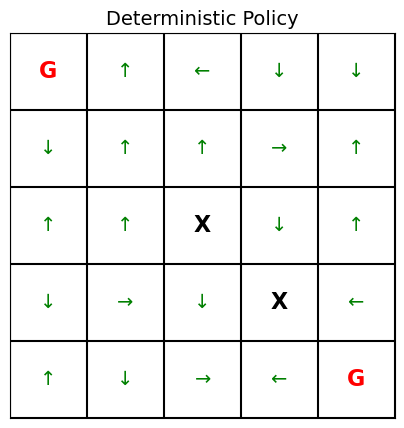

In [3]:
# Create environment
env = GridWorld(height=5, width=5, start=(0, 3), goals=[(4, 4),(0,0)], 
        obstacles=[(2, 2),(3,3)])

# Random stochastic policy
stochastic_policy = env.random_policy()

# Convert to deterministic
policy, rewards = env.deterministic_policy(stochastic_policy)

# Show the arrows of the policy
env.visualise_policy(policy, title="Deterministic Policy")


# Visualise the Random policy

(0, 3)


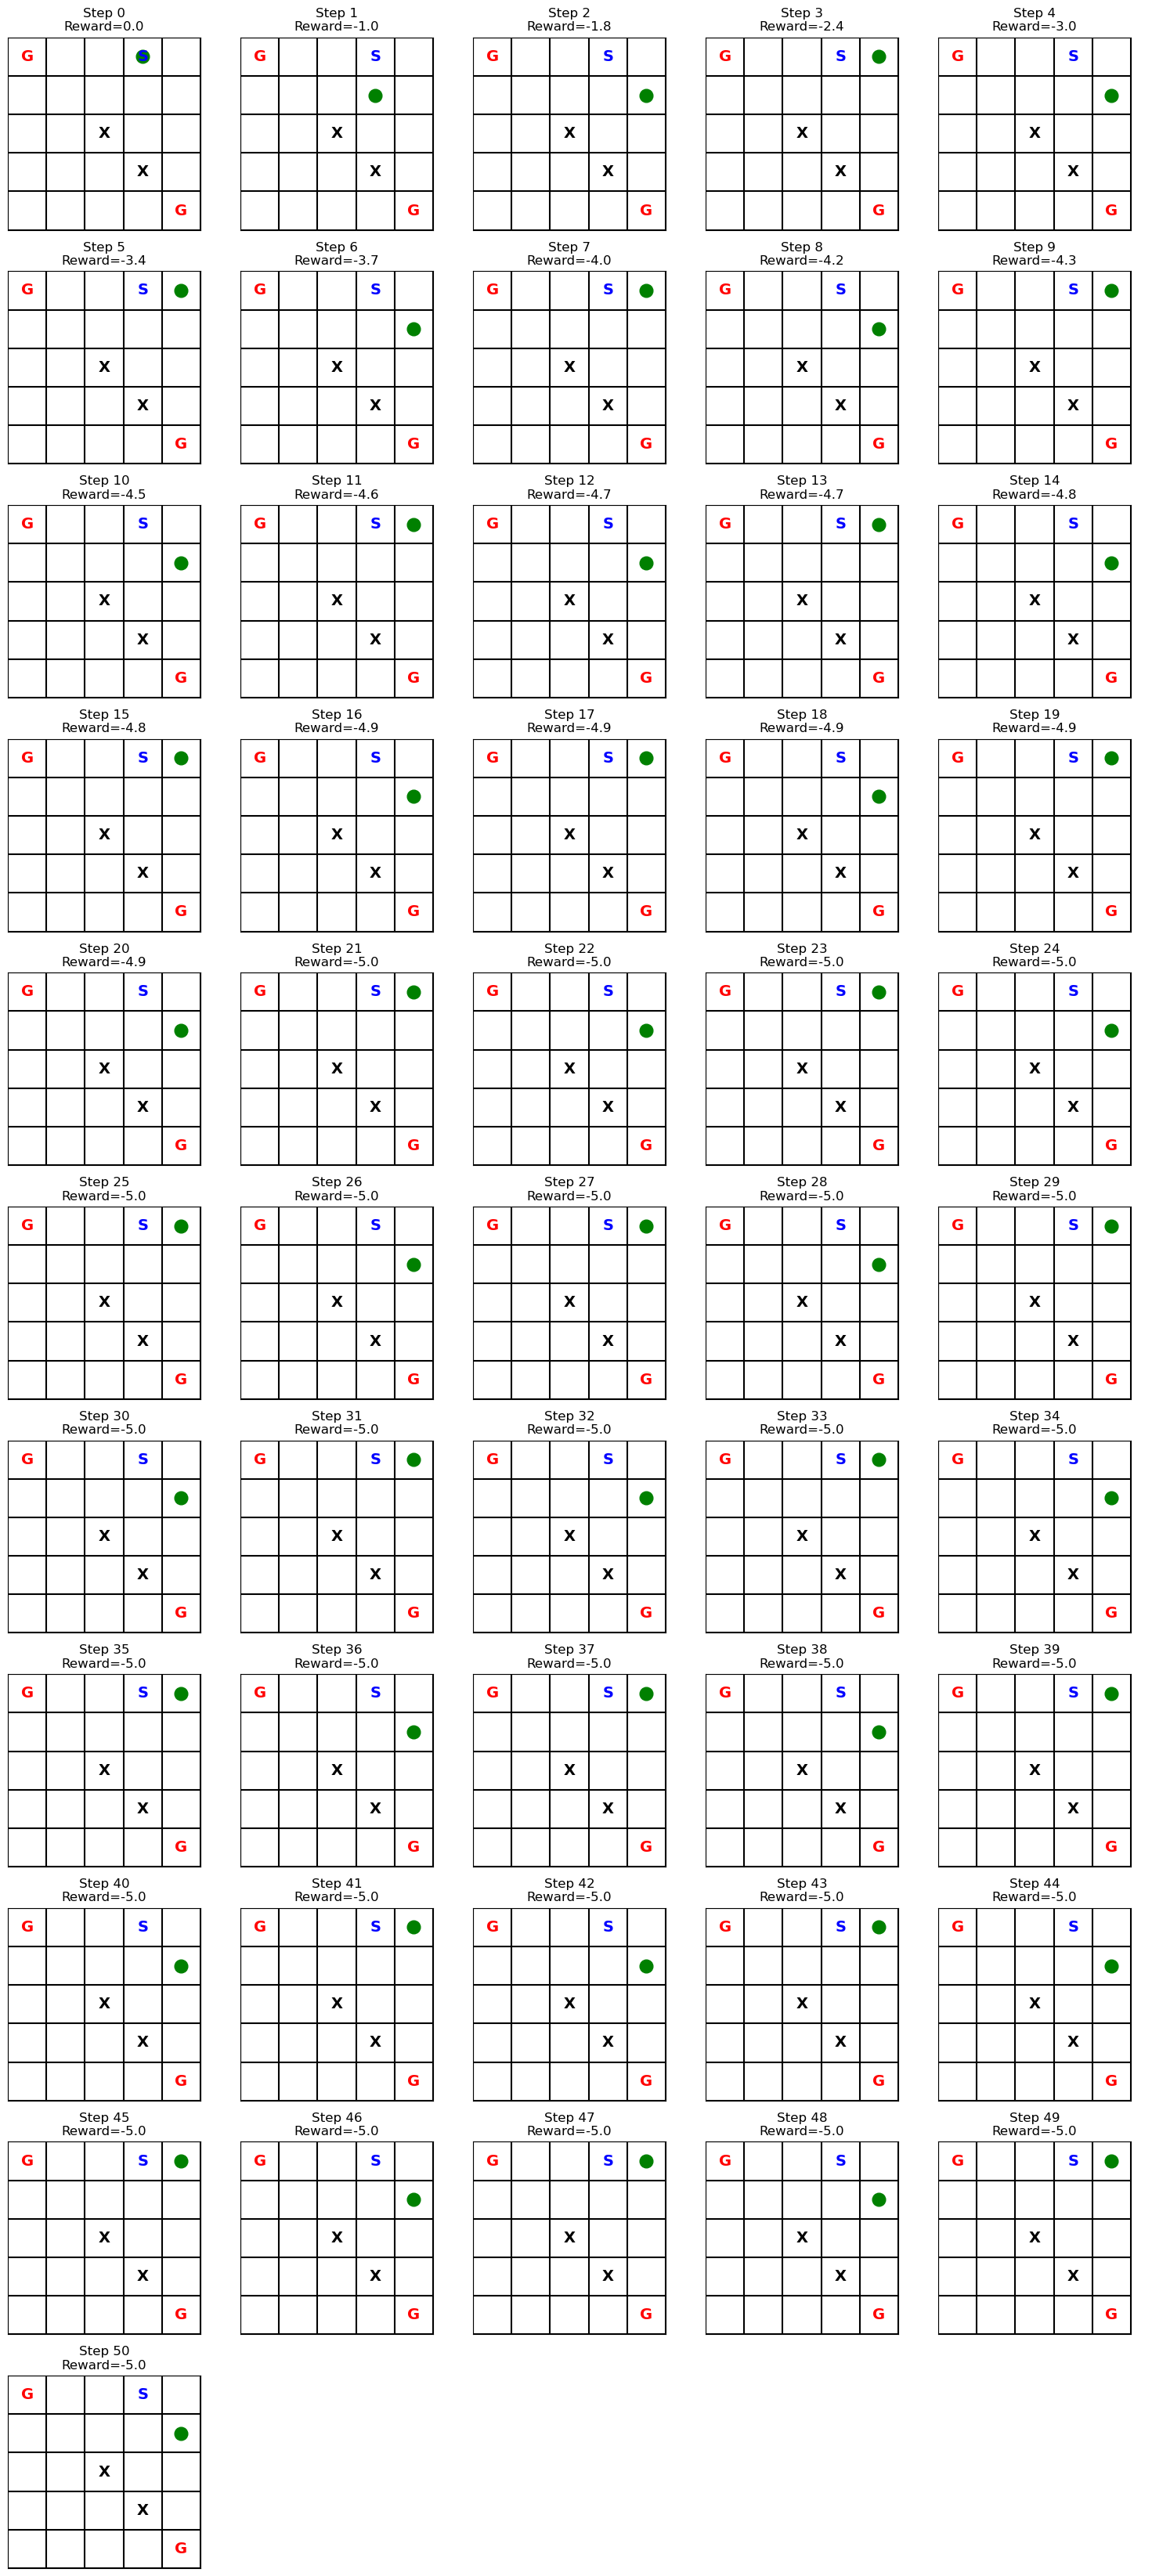

In [4]:
print(f"{env.start}")
env.visualise_episode(policy)


# Test the Algo

In [5]:
# test the value iteration
V_vi , policy_vi = env.value_iteration()

In [6]:
print(V_vi)

{0: 0.0, 1: 5.0, 2: 3.0, 3: 1.4000000000000004, 4: 0.12000000000000033, 5: 5.0, 6: 3.0, 7: 1.4000000000000004, 8: 0.12000000000000033, 9: 1.4000000000000004, 10: 3.0, 11: 1.4000000000000004, 12: 0.0, 13: 1.4000000000000004, 14: 3.0, 15: 1.4000000000000004, 16: 0.12000000000000033, 17: 1.4000000000000004, 18: 0.0, 19: 5.0, 20: 0.12000000000000033, 21: 1.4000000000000004, 22: 3.0, 23: 5.0, 24: 0.0}


In [7]:
env.visualize_values_matrix(V_vi)


array([[0.  , 5.  , 3.  , 1.4 , 0.12],
       [5.  , 3.  , 1.4 , 0.12, 1.4 ],
       [3.  , 1.4 , 0.  , 1.4 , 3.  ],
       [1.4 , 0.12, 1.4 , 0.  , 5.  ],
       [0.12, 1.4 , 3.  , 5.  , 0.  ]])

In [8]:
# ACTIONS = {
#         0: (-1, 0),  # UP
#         1: (1, 0),   # DOWN
#         2: (0, -1),  # LEFT
#         3: (0, 1)    # RIGHT
#     }

In [9]:
print(policy_vi)

{0: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, 1: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}, 2: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}, 3: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}, 4: {0: 0.0, 1: 1.0, 2: 1.0, 3: 0.0}, 5: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}, 6: {0: 1.0, 1: 0.0, 2: 1.0, 3: 0.0}, 7: {0: 1.0, 1: 0.0, 2: 1.0, 3: 0.0}, 8: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}, 9: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 10: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}, 11: {0: 1.0, 1: 0.0, 2: 1.0, 3: 0.0}, 12: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, 13: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 14: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 15: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}, 16: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}, 17: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 18: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, 19: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 20: {0: 1.0, 1: 0.0, 2: 0.0, 3: 1.0}, 21: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 22: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 23: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 24: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}}


In [10]:
# Test the policy ite
# test the value iteration
V_pi , policy_pi = env.policy_iteration()

In [11]:
print(V_pi)

{0: 0.0, 1: 5.0, 2: 3.0, 3: 1.4000000000000004, 4: 0.12000000000000033, 5: 5.0, 6: 6.0, 7: 3.8000000000000007, 8: 2.040000000000001, 9: 1.4000000000000004, 10: 3.0, 11: 3.8000000000000007, 12: 0.0, 13: 1.4000000000000004, 14: 3.0, 15: 1.4000000000000004, 16: 2.040000000000001, 17: 1.4000000000000004, 18: 0.0, 19: 5.0, 20: 0.12000000000000033, 21: 1.4000000000000004, 22: 3.0, 23: 5.0, 24: 0.0}


In [12]:
print(env.visualize_values_matrix(V_pi))

[[0.   5.   3.   1.4  0.12]
 [5.   6.   3.8  2.04 1.4 ]
 [3.   3.8  0.   1.4  3.  ]
 [1.4  2.04 1.4  0.   5.  ]
 [0.12 1.4  3.   5.   0.  ]]


In [13]:
print(policy_pi)

{0: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, 1: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}, 2: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}, 3: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}, 4: {0: 0.0, 1: 1.0, 2: 1.0, 3: 0.0}, 5: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}, 6: {0: 1.0, 1: 0.0, 2: 1.0, 3: 0.0}, 7: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}, 8: {0: 0.0, 1: 0.0, 2: 1.0, 3: 0.0}, 9: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 10: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}, 11: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}, 12: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, 13: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 14: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 15: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}, 16: {0: 1.0, 1: 0.0, 2: 0.0, 3: 0.0}, 17: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 18: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}, 19: {0: 0.0, 1: 1.0, 2: 0.0, 3: 0.0}, 20: {0: 1.0, 1: 0.0, 2: 0.0, 3: 1.0}, 21: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 22: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 23: {0: 0.0, 1: 0.0, 2: 0.0, 3: 1.0}, 24: {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}}


# Convergence courbe

Training on Grid 3x3 ...


Grid 3x3: moyenne(V) = 1.593
Training on Grid 4x4 ...
Grid 4x4: moyenne(V) = 0.737
Training on Grid 5x5 ...
Grid 5x5: moyenne(V) = 0.007
Training on Grid 6x6 ...
Grid 6x6: moyenne(V) = -0.726
Training on Grid 7x7 ...
Grid 7x7: moyenne(V) = -1.197
Training on Grid 8x8 ...
Grid 8x8: moyenne(V) = -1.573


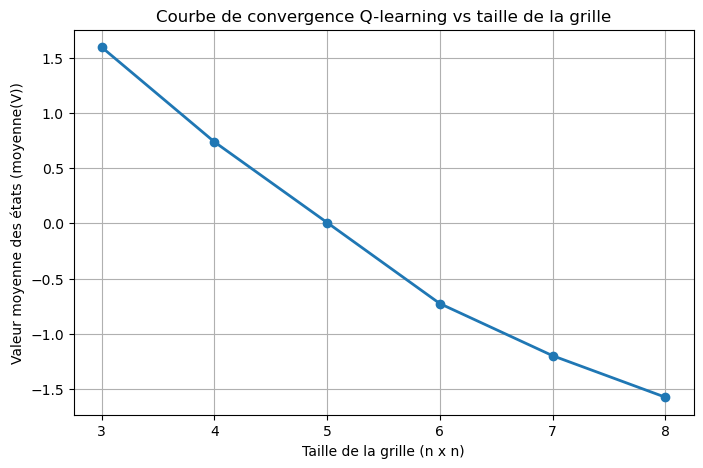

In [14]:
import matplotlib.pyplot as plt
import numpy as np

grid_sizes = [3, 4, 5, 6, 7, 8]
avg_values = []

episodes = 200  # nombre d'épisodes d'apprentissage
alpha = 0.1
epsilon = 0.1

for size in grid_sizes:
    print(f"Training on Grid {size}x{size} ...")
    
    # Création de l'environnement
    env = GridWorld(height=size, width=size, goals=[(size-1, size-1)], obstacles=[(size//2, size//2)])
    
    # Q-learning
    Q, V, policy, history = env.q_learning(
        episodes=episodes,
        alpha=alpha,
        epsilon=epsilon,
        max_steps=100
    )
    
    # Moyenne de la valeur d'état
    mean_V = np.mean(list(V.values()))
    avg_values.append(mean_V)
    print(f"Grid {size}x{size}: moyenne(V) = {mean_V:.3f}")

# --- Tracé de la courbe de convergence ---
plt.figure(figsize=(8, 5))
plt.plot(grid_sizes, avg_values, marker='o', linestyle='-', linewidth=2)
plt.title("Courbe de convergence Q-learning vs taille de la grille")
plt.xlabel("Taille de la grille (n x n)")
plt.ylabel("Valeur moyenne des états (moyenne(V))")
plt.grid(True)
plt.show()


Grid 5x5: temps de convergence = 0.057 sec
Grid 6x6: temps de convergence = 0.052 sec
Grid 7x7: temps de convergence = 0.092 sec
Grid 8x8: temps de convergence = 0.171 sec
Grid 9x9: temps de convergence = 0.175 sec
Grid 10x10: temps de convergence = 0.211 sec
Grid 11x11: temps de convergence = 0.251 sec
Grid 12x12: temps de convergence = 0.584 sec
Grid 13x13: temps de convergence = 0.337 sec
Grid 14x14: temps de convergence = 0.409 sec
Grid 15x15: temps de convergence = 0.542 sec
Grid 16x16: temps de convergence = 0.285 sec
Grid 17x17: temps de convergence = 0.281 sec
Grid 18x18: temps de convergence = 0.279 sec
Grid 19x19: temps de convergence = 0.290 sec
Grid 20x20: temps de convergence = 0.509 sec
Grid 21x21: temps de convergence = 0.348 sec
Grid 22x22: temps de convergence = 0.337 sec
Grid 23x23: temps de convergence = 0.328 sec
Grid 24x24: temps de convergence = 0.315 sec
Grid 25x25: temps de convergence = 0.302 sec


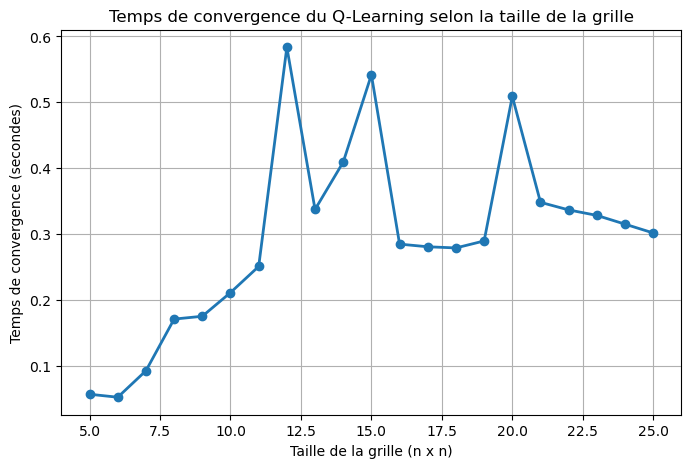

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time

grid_sizes = list(range(5,26))
convergence_times = []
episodes = 500

for size in grid_sizes:
    env = GridWorld(
        height=size,
        width=size,
        goals=[(size - 1, size - 1)],
        obstacles=[(size // 2, size // 2)]
    )
    
    start_time = time.time()
    Q, V, policy , history= env.q_learning(
        episodes=episodes,
        alpha=0.1,
        epsilon=0.1
    )
    end_time = time.time()
    
    elapsed = end_time - start_time
    convergence_times.append(elapsed)
    
    print(f"Grid {size}x{size}: temps de convergence = {elapsed:.3f} sec")

# --- plot the convergence time ---
plt.figure(figsize=(8, 5))
plt.plot(grid_sizes, convergence_times, marker='o', linestyle='-', linewidth=2)
plt.title("Temps de convergence du Q-Learning selon la taille de la grille")
plt.xlabel("Taille de la grille (n x n)")
plt.ylabel("Temps de convergence (secondes)")
plt.grid(True)
plt.show()


In [16]:
env = GridWorld(height=5, width=5, start=(0, 3), goals=[(4, 4),(0,0)], 
        obstacles=[(2, 2),(3,3)])
# Train with Q-learning
Q, V, policy, history = env.q_learning(
    episodes=100,
    alpha=0.1,
    epsilon=0.1,
    record_every=1,
    seed=42
)

# Visualize learning progression
env.visualise_learning(history, gif_name="qlearning_value_policy.gif", interval=300)


GIF saved as qlearning_value_policy.gif


Grid 5x5: Final avg reward = -2.80
Grid 10x10: Final avg reward = -19.94
Grid 15x15: Final avg reward = -69.02
Grid 20x20: Final avg reward = -167.04


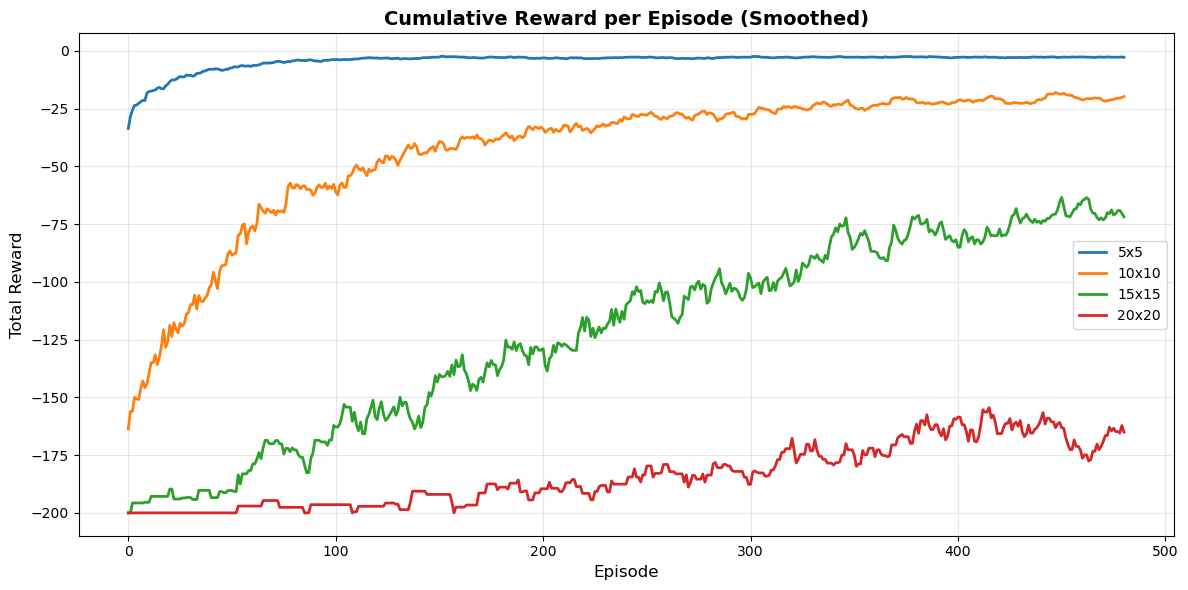

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import random
import time

# ========================================
# CUMULATIVE REWARD ACROSS EPISODES FOR DIFFERENT GRID SIZES
# ========================================

grid_sizes_to_compare = [5, 10, 15, 20]
episodes = 500
alpha = 0.1
epsilon = 0.1

plt.figure(figsize=(12, 6))

for size in grid_sizes_to_compare:
    env = GridWorld(
        height=size,
        width=size,
        goals=[(size - 1, size - 1)],
        obstacles=[(size // 2, size // 2)]
    )
    
    # Track cumulative rewards per episode
    episode_rewards = []
    n_states = size * size
    Q = {s: {a: 0.0 for a in env.ACTIONS} for s in range(n_states)}
    
    for ep in range(episodes):
        state = env.state_index(*env.start)
        total_reward = 0
        
        for _ in range(200):  # max steps per episode
            # ε-greedy action selection
            if np.random.rand() < epsilon:
                action = np.random.choice(list(env.ACTIONS.keys()))
            else:
                action = max(Q[state], key=Q[state].get)
            
            next_state, reward, done = env.step(state, action)
            total_reward += reward
            
            # Q-learning update
            best_next_action = max(Q[next_state], key=Q[next_state].get)
            Q[state][action] += alpha * (
                reward + env.gamma * Q[next_state][best_next_action] - Q[state][action]
            )
            
            state = next_state
            if done:
                break
        
        episode_rewards.append(total_reward)
    
    # Plot cumulative reward (smoothed)
    window = 20
    smoothed_rewards = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label=f'{size}x{size}', linewidth=2)
    print(f"Grid {size}x{size}: Final avg reward = {np.mean(episode_rewards[-50:]):.2f}")

plt.title("Cumulative Reward per Episode (Smoothed)", fontsize=14, fontweight='bold')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Grid 5x5: Avg steps = 8.0 ± 0.0
Grid 7x7: Avg steps = 12.0 ± 0.0
Grid 9x9: Avg steps = 500.0 ± 0.0
Grid 11x11: Avg steps = 500.0 ± 0.0
Grid 13x13: Avg steps = 500.0 ± 0.0
Grid 15x15: Avg steps = 500.0 ± 0.0
Grid 17x17: Avg steps = 500.0 ± 0.0
Grid 19x19: Avg steps = 500.0 ± 0.0
Grid 21x21: Avg steps = 500.0 ± 0.0
Grid 23x23: Avg steps = 500.0 ± 0.0
Grid 25x25: Avg steps = 500.0 ± 0.0


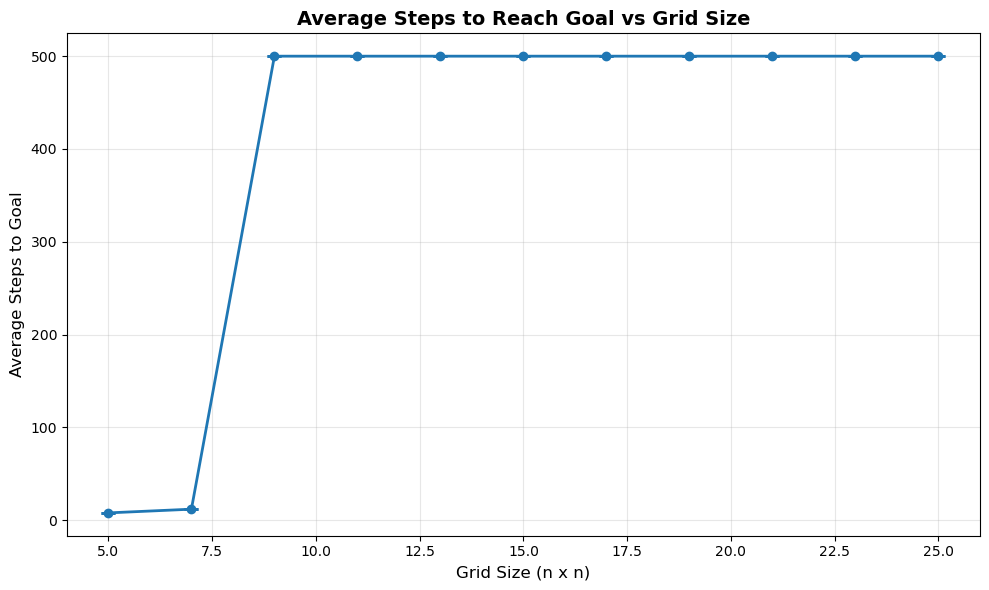

In [18]:
# ========================================
# STEPS TO GOAL vs GRID SIZE
# ========================================

grid_sizes = list(range(5, 26, 2))
avg_steps = []
std_steps = []

for size in grid_sizes:
    env = GridWorld(
        height=size,
        width=size,
        goals=[(size - 1, size - 1)],
        obstacles=[(size // 2, size // 2)]
    )
    
    # Train Q-learning
    Q, V, policy, _ = env.q_learning(episodes=300, alpha=0.1, epsilon=0.1)
    
    # Test the learned policy
    steps_list = []
    for trial in range(50):
        state = env.state_index(*env.start)
        steps = 0
        for _ in range(500):
            action = max(Q[state], key=Q[state].get)
            next_state, _, done = env.step(state, action)
            steps += 1
            state = next_state
            if done:
                break
        steps_list.append(steps)
    
    avg_steps.append(np.mean(steps_list))
    std_steps.append(np.std(steps_list))
    print(f"Grid {size}x{size}: Avg steps = {np.mean(steps_list):.1f} ± {np.std(steps_list):.1f}")

plt.figure(figsize=(10, 6))
plt.errorbar(grid_sizes, avg_steps, yerr=std_steps, marker='o', linestyle='-', 
             linewidth=2, capsize=5, capthick=2)
plt.title("Average Steps to Reach Goal vs Grid Size", fontsize=14, fontweight='bold')
plt.xlabel("Grid Size (n x n)", fontsize=12)
plt.ylabel("Average Steps to Goal", fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Density 0%: Final avg reward = -22.76
Density 5%: Final avg reward = -23.28
Density 10%: Final avg reward = -22.12
Density 15%: Final avg reward = -20.82
Density 20%: Final avg reward = -200.00


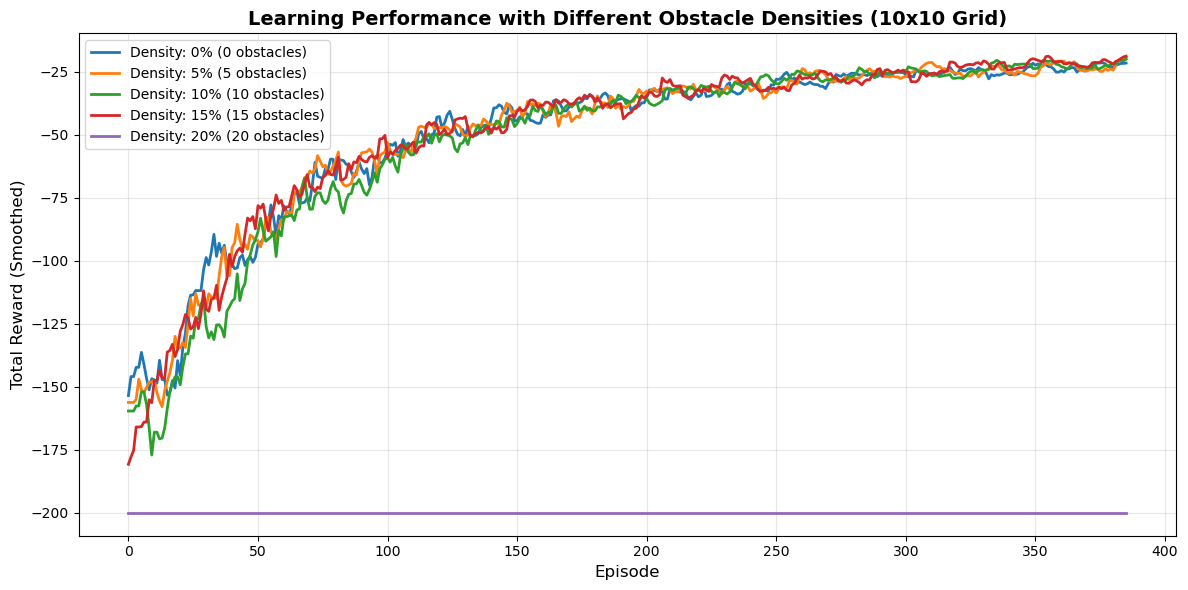

In [19]:
# ========================================
# COMPARISON OF DIFFERENT OBSTACLE DENSITIES
# ========================================


grid_size = 10
episodes = 400
obstacle_densities = [0.0, 0.05, 0.1, 0.15, 0.2]  # percentage of grid cells

plt.figure(figsize=(12, 6))

for density in obstacle_densities:
    n_obstacles = int(grid_size * grid_size * density)
    
    # Generate random obstacles
    all_cells = [(r, c) for r in range(grid_size) for c in range(grid_size)]
    valid_cells = [cell for cell in all_cells if cell != (0, 0) and cell != (grid_size-1, grid_size-1)]
    obstacles = random.sample(valid_cells, min(n_obstacles, len(valid_cells)))
    
    env = GridWorld(
        height=grid_size,
        width=grid_size,
        goals=[(grid_size - 1, grid_size - 1)],
        obstacles=obstacles
    )
    
    # Track rewards
    episode_rewards = []
    n_states = grid_size * grid_size
    Q = {s: {a: 0.0 for a in env.ACTIONS} for s in range(n_states)}
    
    for ep in range(episodes):
        state = env.state_index(*env.start)
        total_reward = 0
        
        for _ in range(200):
            if np.random.rand() < epsilon:
                action = np.random.choice(list(env.ACTIONS.keys()))
            else:
                action = max(Q[state], key=Q[state].get)
            
            next_state, reward, done = env.step(state, action)
            total_reward += reward
            
            best_next_action = max(Q[next_state], key=Q[next_state].get)
            Q[state][action] += alpha * (
                reward + env.gamma * Q[next_state][best_next_action] - Q[state][action]
            )
            
            state = next_state
            if done:
                break
        
        episode_rewards.append(total_reward)
    
    # Smooth and plot
    window = 15
    smoothed_rewards = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(len(smoothed_rewards)), smoothed_rewards, 
             label=f'Density: {density:.0%} ({n_obstacles} obstacles)', linewidth=2)
    print(f"Density {density:.0%}: Final avg reward = {np.mean(episode_rewards[-50:]):.2f}")

plt.title("Learning Performance with Different Obstacle Densities (10x10 Grid)", 
          fontsize=14, fontweight='bold')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward (Smoothed)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Static Obstacles: Final avg reward = -19.20
Dynamic Obstacles: Final avg reward = -29.28
Dynamic Goals: Final avg reward = -132.22
Both Dynamic: Final avg reward = -128.78


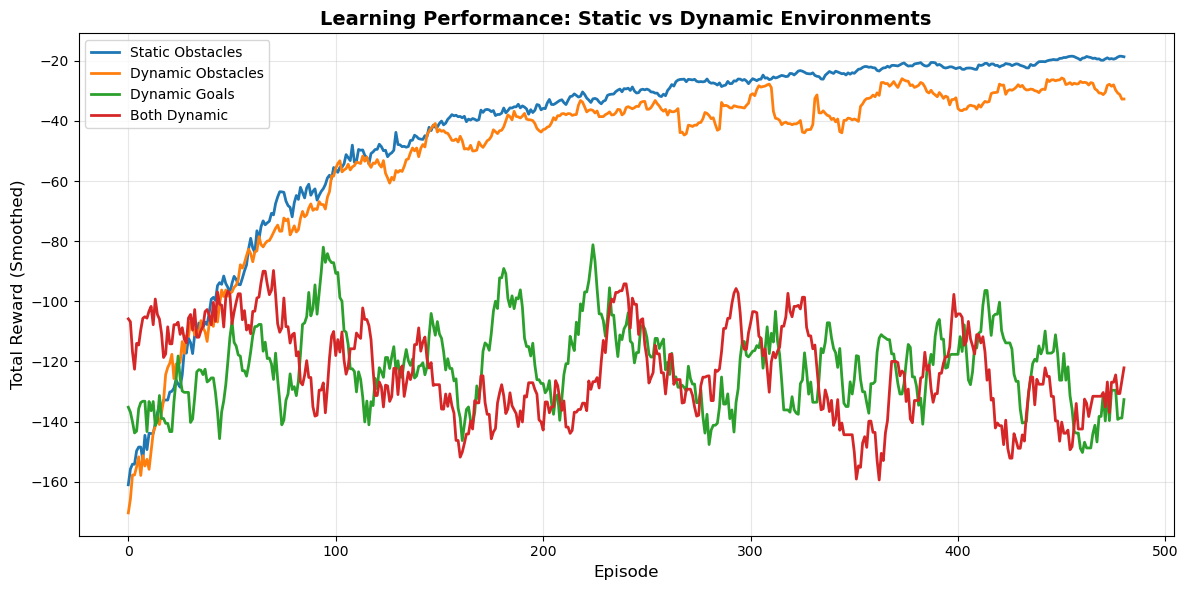

In [20]:
# ========================================
# COMPARISON: STATIC vs DYNAMIC OBSTACLES
# ========================================

grid_size = 10
episodes = 500

configurations = [
    ("Static Obstacles", False, False),
    ("Dynamic Obstacles", True, False),
    ("Dynamic Goals", False, True),
    ("Both Dynamic", True, True)
]

plt.figure(figsize=(12, 6))

for config_name, obstacle_dyn, goal_dyn in configurations:
    env = GridWorld(
        height=grid_size,
        width=grid_size,
        goals=[(grid_size - 1, grid_size - 1)],
        obstacles=[(grid_size // 2, grid_size // 2), (grid_size // 2 + 1, grid_size // 2)],
        obstacle_dynamic=obstacle_dyn,
        goal_dynamic=goal_dyn,
        n_dynamic_obstacles=3,
        n_dynamic_goals=1
    )
    
    episode_rewards = []
    n_states = grid_size * grid_size
    Q = {s: {a: 0.0 for a in env.ACTIONS} for s in range(n_states)}
    
    for ep in range(episodes):
        # Update dynamics
        if obstacle_dyn:
            env._update_dynamic_obstacles()
        if goal_dyn:
            env._update_dynamic_goals()
        
        state = env.state_index(*env.start)
        total_reward = 0
        
        for _ in range(200):
            if np.random.rand() < epsilon:
                action = np.random.choice(list(env.ACTIONS.keys()))
            else:
                action = max(Q[state], key=Q[state].get)
            
            next_state, reward, done = env.step(state, action)
            total_reward += reward
            
            best_next_action = max(Q[next_state], key=Q[next_state].get)
            Q[state][action] += alpha * (
                reward + env.gamma * Q[next_state][best_next_action] - Q[state][action]
            )
            
            state = next_state
            if done:
                break
        
        episode_rewards.append(total_reward)
    
    window = 20
    smoothed_rewards = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(len(smoothed_rewards)), smoothed_rewards, label=config_name, linewidth=2)
    print(f"{config_name}: Final avg reward = {np.mean(episode_rewards[-50:]):.2f}")

plt.title("Learning Performance: Static vs Dynamic Environments", fontsize=14, fontweight='bold')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward (Smoothed)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




Alpha 0.01: Final avg reward = -105.32
Alpha 0.05: Final avg reward = -36.54
Alpha 0.1: Final avg reward = -23.30
Alpha 0.3: Final avg reward = -14.04
Alpha 0.5: Final avg reward = -13.82


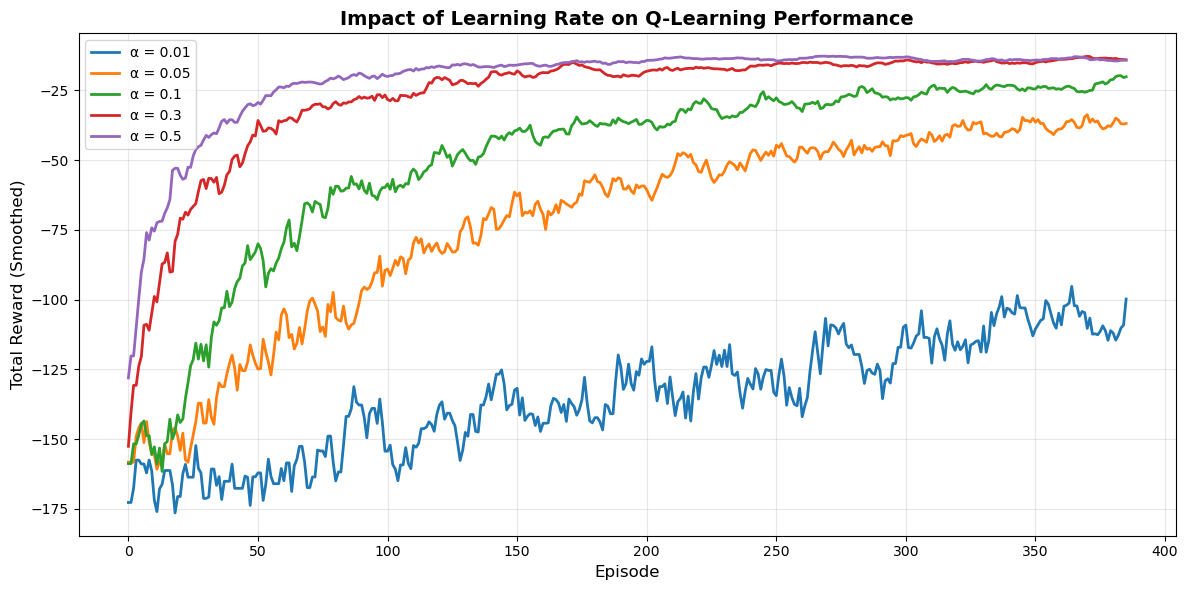

In [21]:
# ========================================
# LEARNING RATE COMPARISON
# ========================================
grid_size = 10
episodes = 400
alphas = [0.01, 0.05, 0.1, 0.3, 0.5]

plt.figure(figsize=(12, 6))

for alpha_val in alphas:
    env = GridWorld(
        height=grid_size,
        width=grid_size,
        goals=[(grid_size - 1, grid_size - 1)],
        obstacles=[(grid_size // 2, grid_size // 2)]
    )
    
    episode_rewards = []
    n_states = grid_size * grid_size
    Q = {s: {a: 0.0 for a in env.ACTIONS} for s in range(n_states)}
    
    for ep in range(episodes):
        state = env.state_index(*env.start)
        total_reward = 0
        
        for _ in range(200):
            if np.random.rand() < epsilon:
                action = np.random.choice(list(env.ACTIONS.keys()))
            else:
                action = max(Q[state], key=Q[state].get)
            
            next_state, reward, done = env.step(state, action)
            total_reward += reward
            
            best_next_action = max(Q[next_state], key=Q[next_state].get)
            Q[state][action] += alpha_val * (
                reward + env.gamma * Q[next_state][best_next_action] - Q[state][action]
            )
            
            state = next_state
            if done:
                break
        
        episode_rewards.append(total_reward)
    
    window = 15
    smoothed_rewards = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(len(smoothed_rewards)), smoothed_rewards, 
             label=f'α = {alpha_val}', linewidth=2)
    print(f"Alpha {alpha_val}: Final avg reward = {np.mean(episode_rewards[-50:]):.2f}")

plt.title("Impact of Learning Rate on Q-Learning Performance", fontsize=14, fontweight='bold')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward (Smoothed)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()



=== Different Exploration Rates (Epsilon) ===
Epsilon 0.01: Final avg reward = -22.06
Epsilon 0.05: Final avg reward = -22.44
Epsilon 0.1: Final avg reward = -23.08
Epsilon 0.2: Final avg reward = -25.06
Epsilon 0.5: Final avg reward = -35.06
Epsilon 0.9: Final avg reward = -134.46


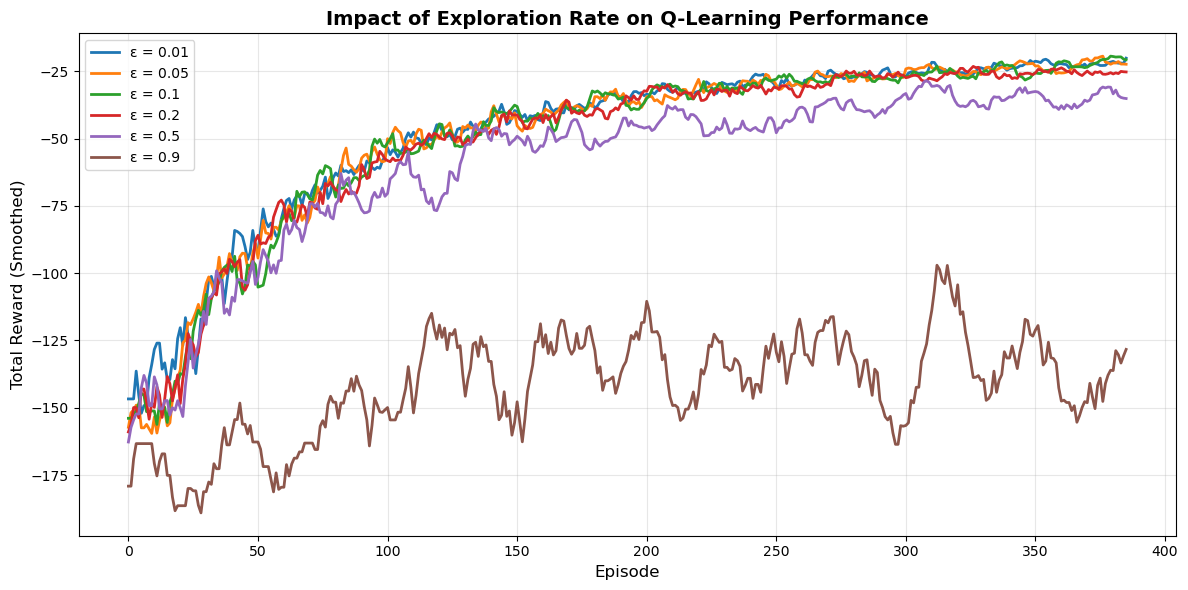

In [22]:
# ========================================
# EXPLORATION RATE (EPSILON) COMPARISON
# ========================================

print("\n=== Different Exploration Rates (Epsilon) ===")
grid_size = 10
episodes = 400
epsilons = [0.01, 0.05, 0.1, 0.2, 0.5, 0.9]

plt.figure(figsize=(12, 6))

for eps_val in epsilons:
    env = GridWorld(
        height=grid_size,
        width=grid_size,
        goals=[(grid_size - 1, grid_size - 1)],
        obstacles=[(grid_size // 2, grid_size // 2)]
    )
    
    episode_rewards = []
    n_states = grid_size * grid_size
    Q = {s: {a: 0.0 for a in env.ACTIONS} for s in range(n_states)}
    
    for ep in range(episodes):
        state = env.state_index(*env.start)
        total_reward = 0
        
        for _ in range(200):
            if np.random.rand() < eps_val:
                action = np.random.choice(list(env.ACTIONS.keys()))
            else:
                action = max(Q[state], key=Q[state].get)
            
            next_state, reward, done = env.step(state, action)
            total_reward += reward
            
            best_next_action = max(Q[next_state], key=Q[next_state].get)
            Q[state][action] += alpha * (
                reward + env.gamma * Q[next_state][best_next_action] - Q[state][action]
            )
            
            state = next_state
            if done:
                break
        
        episode_rewards.append(total_reward)
    
    window = 15
    smoothed_rewards = np.convolve(episode_rewards, np.ones(window)/window, mode='valid')
    plt.plot(range(len(smoothed_rewards)), smoothed_rewards, 
             label=f'ε = {eps_val}', linewidth=2)
    print(f"Epsilon {eps_val}: Final avg reward = {np.mean(episode_rewards[-50:]):.2f}")

plt.title("Impact of Exploration Rate on Q-Learning Performance", fontsize=14, fontweight='bold')
plt.xlabel("Episode", fontsize=12)
plt.ylabel("Total Reward (Smoothed)", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Running Experiment 1: Q-Learning with Static vs Dynamic Goals...
Running Experiment 2: Tracking Episode Rewards...


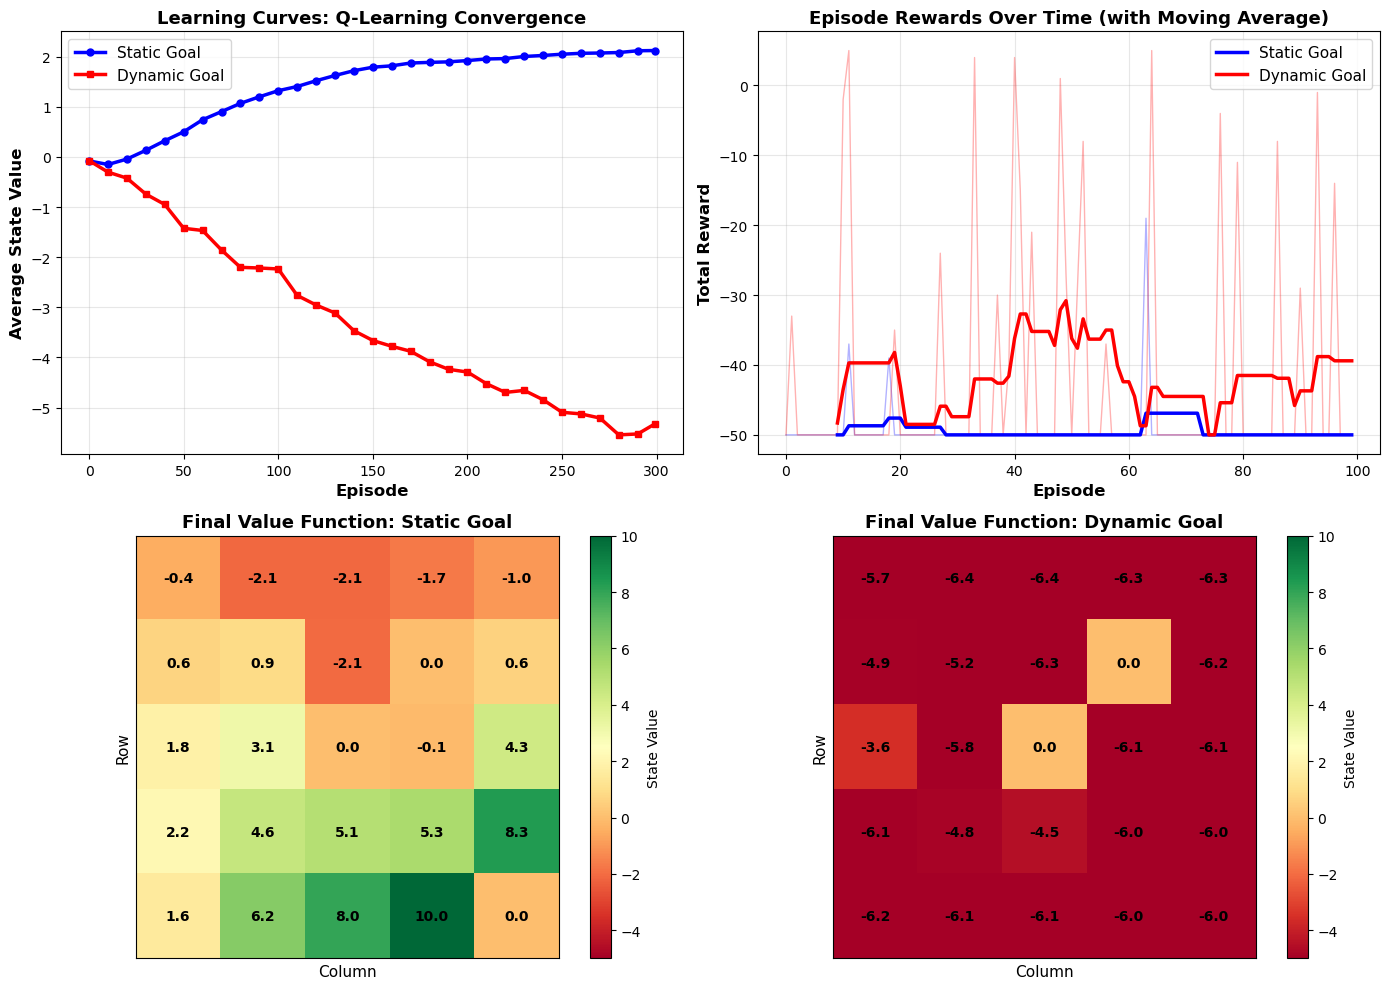


ANALYSIS COMPLETE - Key Findings:
1. Static Goal - Average Reward: -49.45 ± 3.49
2. Dynamic Goal - Average Reward: -41.99 ± 16.30
3. Reward Variance Increase: 366.5%
4. Static Final Avg Value: 2.12
5. Dynamic Final Avg Value: -5.33
6. Value Function Difference: 7.45


In [23]:
import random
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# ============================================================================
# EXPERIMENT 1: Compare Q-Learning Performance - Static vs Dynamic Goals
# ============================================================================

print("Running Experiment 1: Q-Learning with Static vs Dynamic Goals...")

# Static goal environment
env_static = GridWorld(
    height=5, width=5,
    start=(0, 0),
    goals=[(4, 4)],
    obstacles=[(2, 2), (1, 3)],
    goal_reward=10,
    obstacle_reward=-10,
    step_penalty=-1,
    gamma=0.9,
    goal_dynamic=False
)

# Dynamic goal environment (goal changes every episode)
env_dynamic = GridWorld(
    height=5, width=5,
    start=(0, 0),
    goals=[(4, 4)],
    obstacles=[(2, 2), (1, 3)],
    goal_reward=10,
    obstacle_reward=-10,
    step_penalty=-1,
    gamma=0.9,
    goal_dynamic=True,
    n_dynamic_goals=1
)

# Train both agents
episodes = 300
Q_static, V_static, policy_static, history_static = env_static.q_learning(
    episodes=episodes, alpha=0.1, epsilon=0.1, record_every=10
)

Q_dynamic, V_dynamic, policy_dynamic, history_dynamic = env_dynamic.q_learning(
    episodes=episodes, alpha=0.1, epsilon=0.1, record_every=10
)

# Extract learning curves
static_episodes = [h[2] for h in history_static]
static_values = [np.mean(list(h[0].values())) for h in history_static]

dynamic_episodes = [h[2] for h in history_dynamic]
dynamic_values = [np.mean(list(h[0].values())) for h in history_dynamic]

# ============================================================================
# EXPERIMENT 2: Episode Reward Tracking
# ============================================================================

print("Running Experiment 2: Tracking Episode Rewards...")

def run_episodes_with_tracking(env, policy_type='q_learning', n_episodes=100):
    """Run episodes and track rewards."""
    episode_rewards = []
    episode_lengths = []
    
    for ep in range(n_episodes):
        if env.goal_dynamic:
            env._update_dynamic_goals()
        
        state = env.state_index(*env.start)
        total_reward = 0
        steps = 0
        done = False
        
        # Simple epsilon-greedy with random Q-values for initial exploration
        Q_temp = {s: {a: random.random() for a in env.ACTIONS} for s in range(env.height * env.width)}
        
        while not done and steps < 50:
            if random.random() < 0.1:
                action = random.choice(list(env.ACTIONS.keys()))
            else:
                action = max(Q_temp[state], key=Q_temp[state].get)
            
            next_state, reward, done = env.step(state, action)
            total_reward += reward
            steps += 1
            state = next_state
        
        episode_rewards.append(total_reward)
        episode_lengths.append(steps)
    
    return episode_rewards, episode_lengths

# Track rewards for both environments
env_track_static = GridWorld(height=5, width=5, start=(0, 0), goals=[(4, 4)], 
                              obstacles=[(2, 2)], goal_dynamic=False, gamma=0.9)
env_track_dynamic = GridWorld(height=5, width=5, start=(0, 0), goals=[(4, 4)], 
                               obstacles=[(2, 2)], goal_dynamic=True, gamma=0.9)

rewards_static, lengths_static = run_episodes_with_tracking(env_track_static, n_episodes=100)
rewards_dynamic, lengths_dynamic = run_episodes_with_tracking(env_track_dynamic, n_episodes=100)

# ============================================================================
# PLOTTING THE 4 BEST PLOTS
# ============================================================================

fig = plt.figure(figsize=(14, 10))

# Plot 1: Learning Curves (Average State Value)
ax1 = plt.subplot(2, 2, 1)
ax1.plot(static_episodes, static_values, 'b-o', label='Static Goal', linewidth=2.5, markersize=5)
ax1.plot(dynamic_episodes, dynamic_values, 'r-s', label='Dynamic Goal', linewidth=2.5, markersize=5)
ax1.set_xlabel('Episode', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average State Value', fontsize=12, fontweight='bold')
ax1.set_title('Learning Curves: Q-Learning Convergence', fontsize=13, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Plot 2: Episode Rewards Over Time with Moving Average
ax2 = plt.subplot(2, 2, 2)
ax2.plot(rewards_static, 'b-', alpha=0.3, linewidth=1)
ax2.plot(rewards_dynamic, 'r-', alpha=0.3, linewidth=1)
# Add moving average
window = 10
if len(rewards_static) >= window:
    ma_static = np.convolve(rewards_static, np.ones(window)/window, mode='valid')
    ma_dynamic = np.convolve(rewards_dynamic, np.ones(window)/window, mode='valid')
    ax2.plot(range(window-1, len(rewards_static)), ma_static, 'b-', linewidth=2.5, label='Static Goal')
    ax2.plot(range(window-1, len(rewards_dynamic)), ma_dynamic, 'r-', linewidth=2.5, label='Dynamic Goal')
ax2.set_xlabel('Episode', fontsize=12, fontweight='bold')
ax2.set_ylabel('Total Reward', fontsize=12, fontweight='bold')
ax2.set_title('Episode Rewards Over Time (with Moving Average)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

# Plot 3: Value Function - Static Goal (Final)
ax3 = plt.subplot(2, 2, 3)
V_matrix_static = np.array([V_static[s] for s in range(25)]).reshape(5, 5)
im3 = ax3.imshow(V_matrix_static, cmap='RdYlGn', origin='upper', vmin=-5, vmax=10)
ax3.set_title('Final Value Function: Static Goal', fontsize=13, fontweight='bold')
for r in range(5):
    for c in range(5):
        ax3.text(c, r, f'{V_matrix_static[r,c]:.1f}', ha='center', va='center', 
                fontsize=10, fontweight='bold')
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_xlabel('Column', fontsize=11)
ax3.set_ylabel('Row', fontsize=11)
plt.colorbar(im3, ax=ax3, label='State Value')

# Plot 4: Value Function - Dynamic Goal (Final)
ax4 = plt.subplot(2, 2, 4)
V_matrix_dynamic = np.array([V_dynamic[s] for s in range(25)]).reshape(5, 5)
im4 = ax4.imshow(V_matrix_dynamic, cmap='RdYlGn', origin='upper', vmin=-5, vmax=10)
ax4.set_title('Final Value Function: Dynamic Goal', fontsize=13, fontweight='bold')
for r in range(5):
    for c in range(5):
        ax4.text(c, r, f'{V_matrix_dynamic[r,c]:.1f}', ha='center', va='center', 
                fontsize=10, fontweight='bold')
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_xlabel('Column', fontsize=11)
ax4.set_ylabel('Row', fontsize=11)
plt.colorbar(im4, ax=ax4, label='State Value')

plt.tight_layout()
plt.savefig('dynamic_goal_4plots.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("ANALYSIS COMPLETE - Key Findings:")
print("="*70)
print(f"1. Static Goal - Average Reward: {np.mean(rewards_static):.2f} ± {np.std(rewards_static):.2f}")
print(f"2. Dynamic Goal - Average Reward: {np.mean(rewards_dynamic):.2f} ± {np.std(rewards_dynamic):.2f}")
print(f"3. Reward Variance Increase: {(np.std(rewards_dynamic)/np.std(rewards_static) - 1)*100:.1f}%")
print(f"4. Static Final Avg Value: {np.mean(list(V_static.values())):.2f}")
print(f"5. Dynamic Final Avg Value: {np.mean(list(V_dynamic.values())):.2f}")
print(f"6. Value Function Difference: {abs(np.mean(list(V_static.values())) - np.mean(list(V_dynamic.values()))):.2f}")
print("="*70)